In [ ]:
from torchvision import transforms
from PIL import Image
import torch
device="cuda" if torch.cuda.is_available() else "cpu"
img=Image.open("2009_224859.jpg")
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整尺寸到 224x224
    transforms.ToTensor()             # 转换为张量
])
img=transform(img)

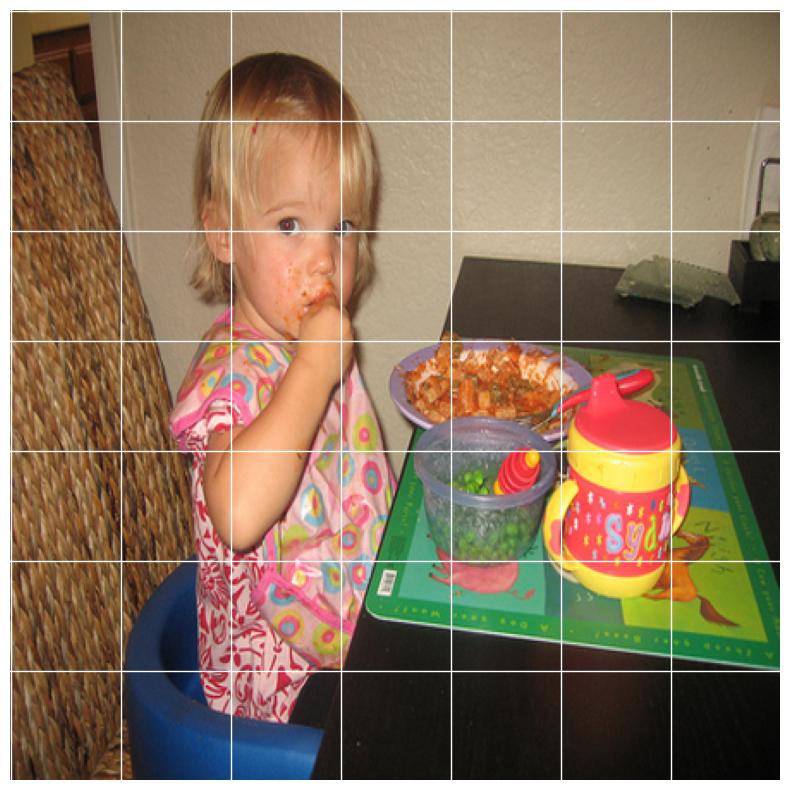

In [ ]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 加载图像
image_path = 'kid.jpg'  # 替换为你的图像路径
image = Image.open(image_path).convert("RGB")
image=image.resize((448,448))
image = np.array(image)

# 设置补丁大小和步幅
patch_size = 64  # 补丁的大小
stride = 64      # 每次滑动的步幅

# 可视化补丁边界的图像
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)

# 绘制网格线以表示补丁边界
for x in range(0, image.shape[1], stride):
    ax.axvline(x, color='white', linestyle='-', linewidth=1)
for y in range(0, image.shape[0], stride):
    ax.axhline(y, color='white', linestyle='-', linewidth=1)

# 隐藏坐标轴
ax.axis('off')

# 显示图像
plt.show()

In [ ]:
img.shape

torch.Size([3, 224, 224])

In [ ]:
patches=img.unfold(0,3,3)
patches.shape

torch.Size([1, 224, 224, 3])

In [ ]:
patch=16
patches=patches.unfold(1,patch,patch)
patches.shape

torch.Size([1, 14, 224, 3, 16])

In [ ]:
patches=patches.unfold(2,patch,patch)
patches.shape

torch.Size([1, 14, 14, 3, 16, 16])

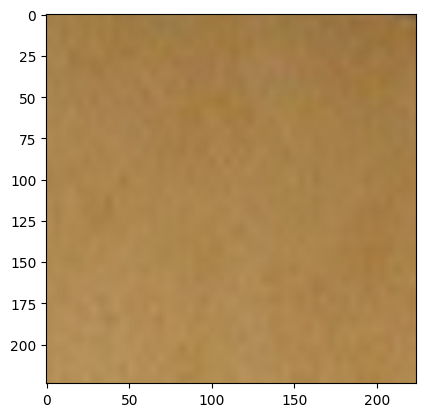

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(patches[0][1][1].permute(1,2,0))
plt.show()

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch

# define processor and model
model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

# move model to device if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [ ]:
window =4
stride = 1

scores = torch.zeros(patches.shape[1], patches.shape[2])
runs = torch.ones(patches.shape[1], patches.shape[2])

for Y in range(0, patches.shape[1]-window+1, stride):
    for X in range(0, patches.shape[2]-window+1, stride):
        big_patch = torch.zeros(patch*window, patch*window, 3)
        patch_batch = patches[0, Y:Y+window, X:X+window]
        for y in range(window):
            for x in range(window):
                big_patch[
                    y*patch:(y+1)*patch, x*patch:(x+1)*patch, :
                ] = patch_batch[y, x].permute(1, 2, 0)
        # we preprocess the image and class label with the CLIP processor
        inputs = processor(
            images=big_patch,  # big patch image sent to CLIP
            return_tensors="pt",  # tell CLIP to return pytorch tensor
            text="a woman",  # class label sent to CLIP
            padding=True
        ).to(device) # move to device if possible

        # calculate and retrieve similarity score
        score = model(**inputs).logits_per_image.item()
        # sum up similarity scores from current and previous big patches
        # that were calculated for patches within the current window
        scores[Y:Y+window, X:X+window] += score
        # calculate the number of runs on each patch within the current window
        runs[Y:Y+window, X:X+window] += 1

In [ ]:
scores

tensor([[ 21.3949,  42.7965,  64.2361,  85.6679,  85.6746,  85.6331,  85.5851,
          85.4958,  85.4135,  85.3760,  85.2988,  63.9563,  42.6370,  21.3144],
        [ 42.6913,  85.4361, 128.2835, 171.0719, 171.1814, 171.1803, 171.0835,
         170.9822, 170.9348, 170.8901, 170.8209, 128.1338,  85.3804,  42.6814],
        [ 63.9890, 127.9901, 192.0464, 256.1287, 256.1590, 256.1659, 256.1551,
         256.0789, 256.2089, 256.2144, 256.2522, 192.2461, 128.0969,  64.0834],
        [ 85.1900, 170.4082, 255.7735, 341.1181, 341.1586, 341.1424, 341.2150,
         341.2408, 341.6234, 341.7917, 341.7798, 256.4093, 170.7964,  85.4260],
        [ 85.0441, 170.1042, 255.3078, 340.5504, 340.5610, 340.5853, 340.7595,
         340.8295, 341.5092, 341.7752, 341.7863, 256.4738, 170.7395,  85.3889],
        [ 85.0557, 170.0563, 255.1613, 340.3203, 340.2007, 340.2330, 340.3750,
         340.3839, 341.0136, 341.1945, 341.1992, 256.0313, 170.4654,  85.2517],
        [ 85.0141, 170.0522, 255.2029, 340.347

In [ ]:
runs

tensor([[ 2.,  3.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  4.,  3.,  2.],
        [ 3.,  5.,  7.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  7.,  5.,  3.],
        [ 4.,  7., 10., 13., 13., 13., 13., 13., 13., 13., 13., 10.,  7.,  4.],
        [ 5.,  9., 13., 17., 17., 17., 17., 17., 17., 17., 17., 13.,  9.,  5.],
        [ 5.,  9., 13., 17., 17., 17., 17., 17., 17., 17., 17., 13.,  9.,  5.],
        [ 5.,  9., 13., 17., 17., 17., 17., 17., 17., 17., 17., 13.,  9.,  5.],
        [ 5.,  9., 13., 17., 17., 17., 17., 17., 17., 17., 17., 13.,  9.,  5.],
        [ 5.,  9., 13., 17., 17., 17., 17., 17., 17., 17., 17., 13.,  9.,  5.],
        [ 5.,  9., 13., 17., 17., 17., 17., 17., 17., 17., 17., 13.,  9.,  5.],
        [ 5.,  9., 13., 17., 17., 17., 17., 17., 17., 17., 17., 13.,  9.,  5.],
        [ 5.,  9., 13., 17., 17., 17., 17., 17., 17., 17., 17., 13.,  9.,  5.],
        [ 4.,  7., 10., 13., 13., 13., 13., 13., 13., 13., 13., 10.,  7.,  4.],
        [ 3.,  5.,  7.,  9.,  9.,  9.,  

In [ ]:
import numpy as np
scores /= runs
# clip the scores
scores = np.clip(scores-scores.mean(), 0, np.inf)

# normalize scores
scores = (
    scores - scores.min()) / (scores.max() - scores.min()
)

In [ ]:
scores

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.2792, 0.2872, 0.2871, 0.2801, 0.2727, 0.2692,
         0.2660, 0.2609, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4084, 0.7352, 0.7367, 0.7371, 0.7365, 0.7327, 0.7392,
         0.7395, 0.7414, 0.4215, 0.0000, 0.0000],
        [0.0000, 0.2308, 0.7172, 0.9740, 0.9755, 0.9749, 0.9777, 0.9787, 0.9935,
         1.0000, 0.9995, 0.7494, 0.2591, 0.0000],
        [0.0000, 0.2086, 0.6937, 0.9520, 0.9525, 0.9534, 0.9601, 0.9628, 0.9891,
         0.9994, 0.9998, 0.7526, 0.2550, 0.0000],
        [0.0000, 0.2051, 0.6863, 0.9432, 0.9385, 0.9398, 0.9453, 0.9456, 0.9699,
         0.9769, 0.9771, 0.7303, 0.2350, 0.0000],
        [0.0000, 0.2048, 0.6884, 0.9442, 0.9463, 0.9500, 0.9545, 0.9563, 0.9732,
         0.9769, 0.9722, 0.7227, 0.2284, 0.0000],
        [0.0000, 0.2122, 0.6929, 0.9500, 0.9546, 0.9630, 0.9671, 0.9652, 0.9728,
  

In [ ]:
adj_patches = patches.squeeze(0).permute(3, 4, 2, 0, 1)
adj_patches.shape
# multiply patches by scores
adj_patches = adj_patches * scores

# rotate patches to visualize
adj_patches = adj_patches.permute(3, 4, 2, 0, 1)
adj_patches.shape

torch.Size([14, 14, 3, 16, 16])

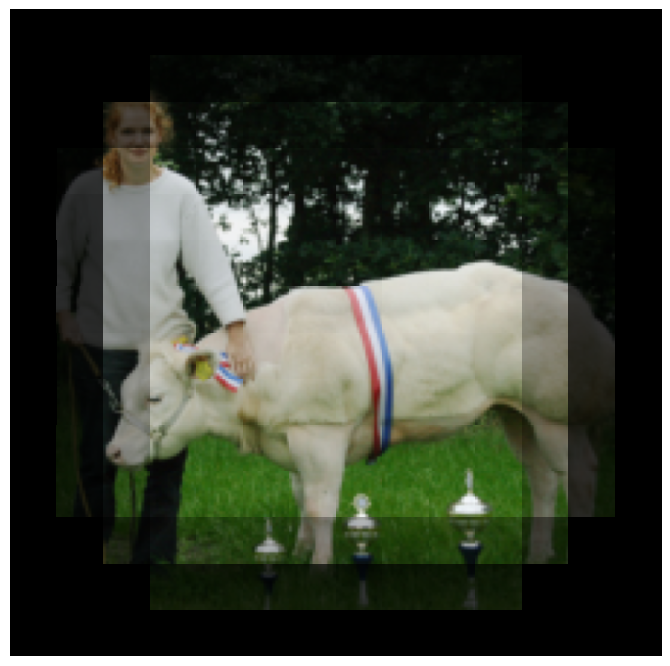

In [ ]:
Y = adj_patches.shape[0]
X = adj_patches.shape[1]

fig, ax = plt.subplots(Y, X,figsize=(X*.6, Y*.6))
for y in range(Y):
    for x in range(X):
        ax[y, x].imshow(adj_patches[y, x].permute(1, 2, 0))
        ax[y, x].axis("off")
        ax[y, x].set_aspect('equal')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
detection = scores > 0.5
np.nonzero(detection)

tensor([[ 2,  3],
        [ 2,  4],
        [ 2,  5],
        [ 2,  6],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 10],
        [ 3,  2],
        [ 3,  3],
        [ 3,  4],
        [ 3,  5],
        [ 3,  6],
        [ 3,  7],
        [ 3,  8],
        [ 3,  9],
        [ 3, 10],
        [ 3, 11],
        [ 4,  2],
        [ 4,  3],
        [ 4,  4],
        [ 4,  5],
        [ 4,  6],
        [ 4,  7],
        [ 4,  8],
        [ 4,  9],
        [ 4, 10],
        [ 4, 11],
        [ 5,  2],
        [ 5,  3],
        [ 5,  4],
        [ 5,  5],
        [ 5,  6],
        [ 5,  7],
        [ 5,  8],
        [ 5,  9],
        [ 5, 10],
        [ 5, 11],
        [ 6,  2],
        [ 6,  3],
        [ 6,  4],
        [ 6,  5],
        [ 6,  6],
        [ 6,  7],
        [ 6,  8],
        [ 6,  9],
        [ 6, 10],
        [ 6, 11],
        [ 7,  2],
        [ 7,  3],
        [ 7,  4],
        [ 7,  5],
        [ 7,  6],
        [ 7,  7],
        [ 7,  8],
        [ 

In [ ]:
y_min, y_max = (
    np.nonzero(detection)[:,0].min().item(),
    np.nonzero(detection)[:,0].max().item()+1
)
y_min, y_max
x_min, x_max = (
    np.nonzero(detection)[:,1].min().item(),
    np.nonzero(detection)[:,1].max().item()+1
)
x_min, x_max
y_min *= patch
y_max *= patch
x_min *= patch
x_max *= patch
x_min, y_min
height = y_max - y_min
width = x_max - x_min

height, width

(160, 160)

In [ ]:
x_min,y_min,x_max,y_max

(32, 32, 192, 192)

In [ ]:
image = np.moveaxis(img.data.numpy(), 0, -1)
image.shape

(224, 224, 3)

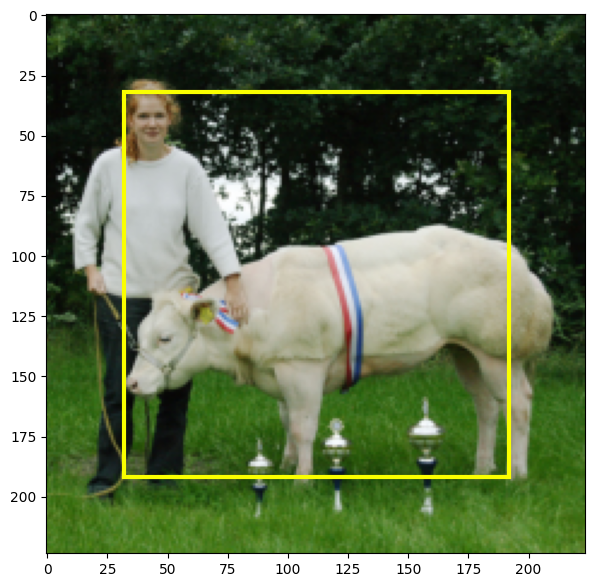

In [ ]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(Y*0.5, X*0.5))

ax.imshow(image)

# Create a Rectangle patch
rect = patches.Rectangle(
    (x_min, y_min), width, height,
    linewidth=3, edgecolor='#FAFF00', facecolor='none'
)

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [ ]:
!pip install selectivesearch

  Preparing metadata (setup.py) ... done
  Created wheel for selectivesearch: filename=selectivesearch-0.4-py3-none-any.whl size=4335 sha256=9866c429231fb9a391fa66c1a3f2c2b55915d354c30704c583169aec80fed295
  Stored in directory: /root/.cache/pip/wheels/0e/49/95/01447a4e0f48a135ac91fbdb1dd2a1c0523e40e29957b383a3
Successfully built selectivesearch


生成的候选区域数量：599


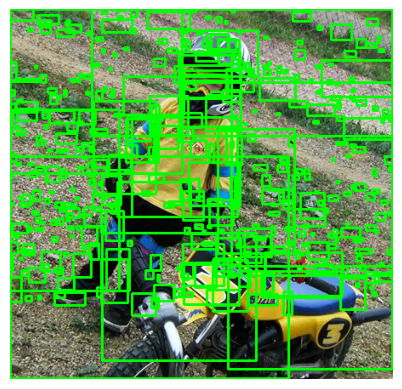

In [ ]:
import cv2
import matplotlib.pyplot as plt
import selectivesearch

def selective_search(image):
    """
    使用 selectivesearch 库实现区域候选生成。
    """
    # 图像输入需要为 RGB 格式
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    _, regions = selectivesearch.selective_search(
        img_rgb, scale=500, sigma=0.9, min_size=10)

    rects = []
    for region in regions:
        # 过滤掉重复区域
        if region['rect'] not in rects:
            rects.append(region['rect'])
    return rects

def draw_rectangles(image, rects, num_show=400):
    """
    将候选框绘制到图像上。

    Args:
        image: 输入图像。
        rects: 候选区域（矩形框）。
        num_show: 要显示的候选区域数量。
    """
    for i, (x, y, w, h) in enumerate(rects[:num_show]):
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return image

# 示例
image = cv2.imread('kid.jpg')
rects = selective_search(image)

print(f"生成的候选区域数量：{len(rects)}")

# 绘制前 100 个候选框
image_with_rects = draw_rectangles(image.copy(), rects, num_show=400)

# 显示结果
plt.imshow(cv2.cvtColor(image_with_rects, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


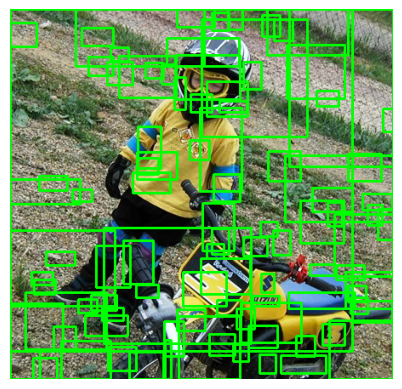

In [ ]:
import cv2
import numpy as np

def edge_based_boxes(image, max_boxes=100):
    """
    使用边缘检测和轮廓提取生成候选框。
    """
    # 转换为灰度图像
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 边缘检测
    edges = cv2.Canny(gray, 50, 150)

    # 轮廓检测
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 根据轮廓生成候选框
    boxes = [cv2.boundingRect(c) for c in contours]

    # 按面积排序并选择前 max_boxes 个框
    boxes = sorted(boxes, key=lambda x: x[2] * x[3], reverse=True)[:max_boxes]

    return boxes

# 示例
image = cv2.imread('kid.jpg')
boxes = edge_based_boxes(image)

# 绘制候选框
for (x, y, w, h) in boxes:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# 显示结果

# 显示结果
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



In [ ]:

!git clone https://github.com/hila-chefer/Transformer-MM-Explainability

import os
os.chdir(f'./Transformer-MM-Explainability')

!pip install einops
!pip install ftfy
!pip install captum

Cloning into 'Transformer-MM-Explainability'...
remote: Enumerating objects: 1477, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 1477 (delta 90), reused 85 (delta 85), pack-reused 1324 (from 1)
Receiving objects: 100% (1477/1477), 25.57 MiB | 17.11 MiB/s, done.
Resolving deltas: 100% (578/578), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.0 MB/s eta 0:00:00


In [ ]:
import torch
import CLIP.clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization

In [ ]:

#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  -1#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  -1#@param {type:"number"}

In [ ]:
def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1:
      # calculate index of last layer
      start_layer = len(image_attn_blocks) - 1

    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]


    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1:
      # calculate index of last layer
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text

    return text_relevance, image_relevance

In [ ]:

def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(image[0].permute(1,2,0).data.cpu().numpy());
    axs[0].axis('off');

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    #image_relevance = torch.nn.functional.interpolate(image_relevance, size=image.shape, mode='bilinear')
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');

In [ ]:
image_relevance

NameError: name 'image_relevance' is not defined

In [ ]:
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
  CLS_idx = text_encoding.argmax(dim=-1)
  R_text = R_text[CLS_idx, 1:CLS_idx]
  text_scores = R_text / R_text.sum()
  text_scores = text_scores.flatten()
  print(text_scores)
  text_tokens=_tokenizer.encode(text)
  text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
  visualization.visualize_text(vis_data_records)

In [ ]:

clip.clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
}


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

100%|███████████████████████████████████████| 354M/354M [00:03<00:00, 91.4MiB/s]


In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


In [ ]:
from PIL import Image
import os

def resize_and_save_image(input_path, output_folder, output_filename):
    # 打开图像
    original_img = Image.open(input_path)

    # 调整图像大小
    resized_img = original_img.resize((224, 224))

    # 确保输出文件夹存在
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 保存调整后的图像
    output_path = os.path.join(output_folder, output_filename)
    resized_img.save(output_path)

    print(f"Image saved at: {output_path}")

# 使用示例
input_image_path = "woman_cat.jpg"  # 输入图像路径
output_directory = "resized"  # 输出文件夹
output_image_name = "woman_cat1.jpg"  # 输出图像文件名

resize_and_save_image(input_image_path, output_directory, output_image_name)

FileNotFoundError: [Errno 2] No such file or directory: 'woman_cat.jpg'

tensor([1.], device='cuda:0', dtype=torch.float16)


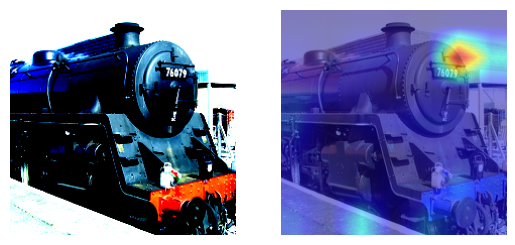

In [ ]:
img_path = "2007_005689.jpg"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["train",]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

In [ ]:
image_relevance = R_image[0].reshape(1, 1, 7, 7)
image_re=torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')

In [ ]:


# 示例二维数组
array = image_re.detach().cpu().numpy()
import numpy as np


# 找到最大值
max_value = np.max(array)

# 找到最大值的位置
max_index = np.unravel_index(np.argmax(array), array.shape)

# 输出结果
print(f"最大值: {max_value}")
print(f"最大值位置: 行 {max_index[0]}, 列 {max_index[1]}")


最大值: 0.0207061767578125
最大值位置: 行 0, 列 0


In [ ]:
R_image.shape
max_value,max_index=torch.max(R_image,dim=1)
max_value,max_index

(tensor([0.0085, 0.0275, 0.0363, 0.0242], device='cuda:0', dtype=torch.float16),
 tensor([ 9, 38, 42, 27], device='cuda:0'))

In [ ]:
pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-9um_dl91
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-9um_dl91
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=5d8658a39fe76cff1bf06b6567068ab0257aaef06926edf803fe3346a767ed00
  Stored in directory: /tmp/pip-ephem-wheel-cache-zpwgjtln/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


In [ ]:
import cv2
image = cv2.imread('2007_005689.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(375, 500, 3)

/content
/content


/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


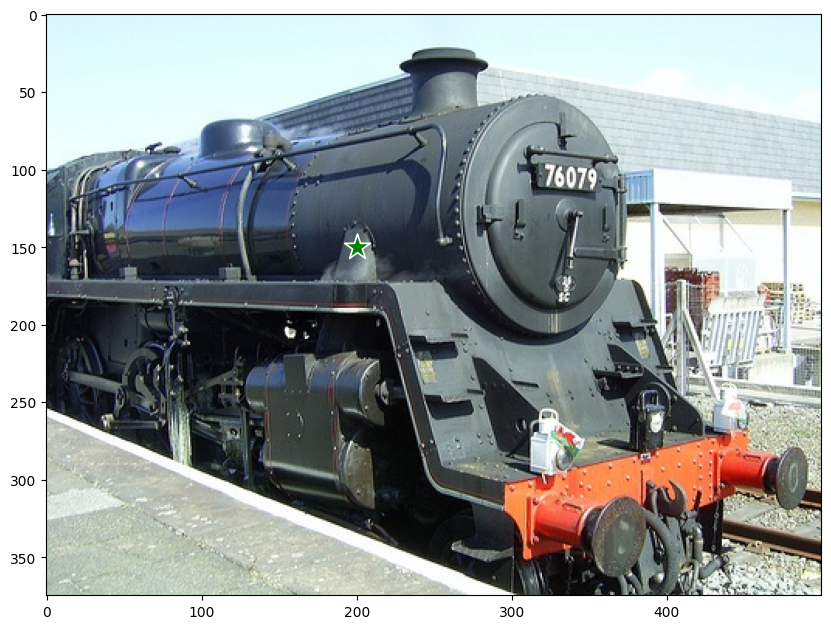

In [25]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
import torch
from segment_anything import sam_model_registry, SamPredictor
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
sam_checkpoint = "drive/MyDrive/sam_vit_b_01ec64.pth"
model_type = "vit_b"
%cd /content
#device = "cuda"
device="cuda" if torch.cuda.is_available() else "cpu"
import os
image = cv2.imread('2007_005689.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.size
current_path = os.getcwd()
print(current_path)
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)
#input_point = np.array([[196.43, 80.36],[89.29, 339.84],[250.00, 300] ,[411, 201]])
#input_point = np.array([[196.43, 80.36],[89.29, 390],[250.00, 300],[411, 201]])
input_point = np.array([[200,150]])
input_label = np.array([1])
#input_box = np.array([0,20,490,375])
plt.figure(figsize=(10,10))
plt.imshow(image)
#show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [ ]:
#input_point = np.array([[170,250]])
#input_label = np.array([1])
masks, scores, logits= predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    #box=input_box,
    multimask_output=True,
)
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    show_box(input_box, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()


In [21]:
import numpy as np
from PIL import Image

# 假设 mask 是 SAM 生成的分割掩码
# mask shape: [H, W], dtype: bool
# image 是原始图像 (仅用于生成纯色结果可视化)

def apply_color_to_segmentation(mask, original_image=None):
    # 创建与掩码相同大小的纯色图像
    H, W = mask.shape
    colored_segmentation = np.zeros((H, W, 3), dtype=np.uint8)

    # 设置分割区域为 (128, 0, 0)，其余区域为 (0, 0, 0)
    colored_segmentation[mask] = [128,192,0]

    # 如果需要可视化，将分割结果覆盖到原始图像上
    #if original_image is not None:
       # original_image = np.asarray(original_image).copy()
        #original_image[~mask] = [0, 0, 0]  # 其他区域为纯黑
        #return Image.fromarray(original_image)

    return Image.fromarray(colored_segmentation)

# 示例用法
# mask 是布尔类型的 SAM 分割结果
# image 是 PIL 图像
#segmentation_mask = masks.squeeze(0)  # 示例随机生成 mask
segmentation_mask = masks[1]  # 示例随机生成 mask
original_image = Image.open("2007_005689.jpg")

# 生成分割纯色图
segmentation_image = apply_color_to_segmentation(segmentation_mask, original_image)

# 保存或显示结果
segmentation_image.save("segmentation_result1.png")
segmentation_image.show()


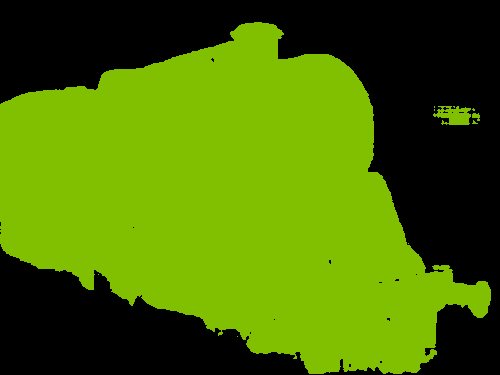

In [22]:
segmentation_image

In [ ]:
masks

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

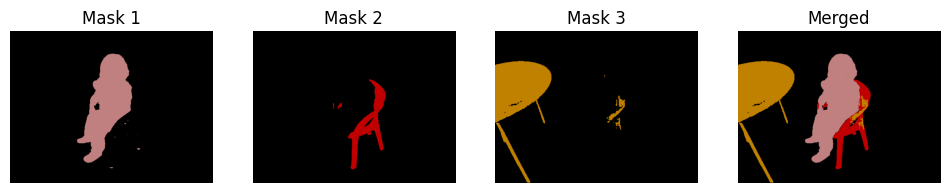

In [ ]:
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

def merge_rgb_masks(masks, background_color=[0, 0, 0]):
    """
    合并多张 RGB 分割结果。

    Args:
        masks: list 或 numpy 数组, 每张分割结果大小为 [H, W, 3]
        background_color: list, 背景颜色的 RGB 值（默认黑色）

    Returns:
        merged_image: 合并后的图像 [H, W, 3]
    """
    # 确保输入是 NumPy 数组
    masks = np.array(masks)  # 转为 [N, H, W, 3]
    num_masks, h, w, c = masks.shape

    # 初始化合并后的图像（全背景色）
    merged_image = np.zeros((h, w, c), dtype=np.uint8)

    for mask in masks:
        # 在背景像素位置上合并
        mask_non_background = (mask != background_color).any(axis=-1)  # 非背景像素
        merged_image[mask_non_background] = mask[mask_non_background]

    return merged_image
# 加载两张纯色图像
mask1 = Image.open('segmentation_result1.png')  # 第一张图像
mask2 = Image.open('segmentation_result2.png')  # 第二张图像
mask3 = Image.open('segmentation_result3.png')
mask1=np.array(mask1)
mask2=np.array(mask2)
mask3=np.array(mask3)
# 示例分割结果 (随机生成三张分割图)
h, w = 375, 500  # 图像大小
merged_result = merge_rgb_masks([mask1, mask2,mask3])
image = cv2.cvtColor(merged_result, cv2.COLOR_BGR2RGB)
cv2.imwrite('merged_img.png', image)

# 可视化
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, img in enumerate([mask1, mask2,mask3, merged_result]):
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f'Mask {i+1}' if i < 3 else 'Merged')
plt.show()


In [23]:
# 分割结果示例 (H=3, W=3)
from PIL import Image
import numpy as np
segmentation_image=Image.open("segmentation_result1.png")
segmentation_image=np.array(segmentation_image)
label_image=Image.open("2007_005689.png")
label_image=np.array(label_image)

def rgb_to_class_map(segmentation_map, class_colors):
    """
    将三通道的分割结果图 (RGB) 转换为类别表示 (单通道类别图)。

    :param segmentation_map: 分割结果图，形状为 [H, W, 3]
    :param class_colors: 每个类别对应的 RGB 值，形状为 [num_classes, 3]
    :return: 单通道类别图，形状为 [H, W]，每个像素值为类别编号
    """
    # 初始化类别图
    height, width, _ = segmentation_map.shape
    class_map = np.zeros((height, width), dtype=np.int32)

    # 遍历每个类别的颜色，将匹配的像素设置为该类别
    for class_idx, color in enumerate(class_colors):
        mask = np.all(segmentation_map == color, axis=-1)
        class_map[mask] = class_idx

    return class_map

# 类别的 RGB 对应表 (假设有 4 类)
class_colors = np.array([
   [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128], [224, 224, 192]

])
pre_class_map = rgb_to_class_map(segmentation_image, class_colors)
pre_class_map

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [ ]:
label_image.shape

(375, 500)

In [ ]:
import numpy as np


# 要查找的值
value_to_count = 5

# 计算出现次数
count1 = np.count_nonzero(pre_class_map == 5)
print(f"值 {value_to_count} 在数组中出现的次数: {count1}")
count2 = np.count_nonzero(label_image == 5)
print(f"值 {value_to_count} 在数组中出现的次数: {count2}")

值 5 在数组中出现的次数: 25533
值 5 在数组中出现的次数: 23642


In [ ]:
label_cls_map.max()

NameError: name 'label_cls_map' is not defined

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist

def calculate_classwise_metrics(prediction, ground_truth, cls):
    """
    计算多类别分割任务中每类别的 IoU、Dice 系数和 Hausdorff 距离。

    :param prediction: 模型预测结果 [H, W]，每个像素为类别值
    :param ground_truth: 真实标签 [H, W]，每个像素为类别值
    :param cls: 当前计算的类别
    :return: 当前类别的 IoU、Dice 系数和 Hausdorff 距离
    """
    # 对当前类别进行二值化
    pred_cls = (prediction == cls)
    gt_cls = (ground_truth == cls)

    # 计算交集和并集
    intersection = np.logical_and(pred_cls, gt_cls).sum()
    union = np.logical_or(pred_cls, gt_cls).sum()

    # IoU
    iou = intersection / union if union > 0 else 0

    # Dice
    tp_fp_fn = pred_cls.sum() + gt_cls.sum()
    dice = (2 * intersection) / tp_fp_fn if tp_fp_fn > 0 else 0

    # Hausdorff Distance (HD)
    # 只考虑非零部分，即边缘点
    pred_indices = np.column_stack(np.where(pred_cls))
    gt_indices = np.column_stack(np.where(gt_cls))

    # 如果没有边缘点，则 Hausdorff 距离为 0
    if len(pred_indices) == 0 or len(gt_indices) == 0:
        hd = 0
    else:
        # 计算每个预测点到真实标签的最短距离，以及反过来的距离
        dist_pred_to_gt = cdist(pred_indices, gt_indices, metric='euclidean')
        dist_gt_to_pred = cdist(gt_indices, pred_indices, metric='euclidean')

        # 计算 HD
        hd = max(dist_pred_to_gt.min(axis=1).max(), dist_gt_to_pred.min(axis=1).max())

    return iou, dice, hd
# 示例预测结果
num_classes = 21

# 计算 IoU 和 Dice
iou,dice,hd = calculate_classwise_metrics(pre_class_map, label_image, 5)
iou,dice,hd


(0.925938980926644, 0.9615455007625826, 4.47213595499958)

In [24]:
import numpy as np

def calculate_classwise_metrics(prediction, ground_truth, cls):
    """
    计算多类别分割任务中每类别的 IoU 和 Dice 系数。

    :param prediction: 模型预测结果 [H, W]，每个像素为类别值
    :param ground_truth: 真实标签 [H, W]，每个像素为类别值
    :param num_classes: 类别数
    :return: 每类别的 IoU 和 Dice，及其均值 (mIoU 和 mDice)
    """

        # 对当前类别进行二值化
    pred_cls = (prediction == cls)
    gt_cls = (ground_truth == cls)

        # 计算交集和并集
    intersection = np.logical_and(pred_cls, gt_cls).sum()
    union = np.logical_or(pred_cls, gt_cls).sum()

        # IoU
    iou = intersection / union if union > 0 else 0

        # Dice
    tp_fp_fn = pred_cls.sum() + gt_cls.sum()
    dice = (2 * intersection) / tp_fp_fn if tp_fp_fn > 0 else 0


    return iou, dice
# 示例预测结果
num_classes = 21

# 计算 IoU 和 Dice
iou,dice = calculate_classwise_metrics(pre_class_map, label_image, 19)
iou,dice

(0.9302369736806416, 0.9638577919340484)

In [ ]:
iou,dice,hd

(0.703976589852119, 0.8262749547670888, 35.90264614203248)

In [ ]:
a=5/2
a

2.5